# Alloy4Fun Data

## Import Data

In [1]:
import pandas as pd, os 
import numpy as np
import collections
import matplotlib.pyplot as plt

def importDataFromDir(dir):
    # Import all the data from a directory
    # dir: directory with the data
    # return: a dictionary of dataframes
    dict = {}

    for file in os.listdir(dir):
        if file.endswith('.json'):
            df = pd.read_json(f'{dir}/' + file, lines=True)
            dict[file.removesuffix(".json")[0:3]] = df
            print(f"Imported {file}.")

    return dict

In [2]:
# Import files from the data directory
dict = importDataFromDir('data')

Imported 9jPK8KBWzjFmBx4Hb.json.
Imported FwCGymHmbqcziisH5.json.
Imported gAeD3MTGCCv8YNTaK.json.
Imported JC8Tij8o8GZb99gEJ.json.
Imported jyS8Bmceejj9pLbTW.json.
Imported PQAJE67kz8w5NWJuM.json.
Imported sDLK7uBCbgZon3znd.json.
Imported WGdhwKZnCu7aKhXq9.json.
Imported YH3ANm7Y5Qe5dSYem.json.
Imported zoEADeCW2b2suJB2k.json.
Imported zRAn69AocpkmxXZnW.json.


## Data Cleaning

### Check null values

In [3]:
df1 = dict["9jP"]
df1.head()

,_id,cmd_c,cmd_i,cmd_n,code,derivationOf,original,sat,time,msg,theme
0,zKAYz8BCDmHKgNoSx,1.0,7.0,prop8Ok,/**\n * Linear temporal logic revision exercis...,dvhCng5AdxC8MqjFy,9jPK8KBWzjFmBx4Hb,1.0,2020-12-13 23:28:11,NaN,NaN
1,8FmQ9PNWT2SXncTxX,1.0,9.0,prop10Ok,/**\n * Linear temporal logic revision exercis...,5eT7wTw5kT8DwTbu2,9jPK8KBWzjFmBx4Hb,1.0,2019-11-11 21:54:33,NaN,NaN
2,eyGu5DYCrnk58G2fJ,1.0,6.0,prop7Ok,/**\n * Linear temporal logic revision exercis...,niLmMRmm94Hz6ymcD,9jPK8KBWzjFmBx4Hb,1.0,2020-12-1 11:55:11,NaN,NaN
3,Akbr9Aq6WfBLHrvE8,1.0,18.0,prop19Ok,/**\n * Linear temporal logic revision exercis...,DnAm62D7JaqDzyy5y,9jPK8KBWzjFmBx4Hb,1.0,2020-11-26 10:33:29,NaN,NaN
4,MNegade3hLiutxCru,1.0,10.0,prop11Ok,/**\n * Linear temporal logic revision exercis...,cjK4u23ZAfYm8fatA,9jPK8KBWzjFmBx4Hb,1.0,2020-1-19 17:06:22,NaN,NaN


In [4]:

df1.isnull().sum()

_id                0
cmd_c            915
cmd_i             35
cmd_n            915
code               0
derivationOf       0
original           0
sat               35
time               0
msg             4353
theme           5218
dtype: int64

Features meaning:
- _id: the id of the interaction
- time: the timestamp of its creation
- derivationOf: the parent entry
- original: the first ancestor with secrets (always the same within an exercise)
- code: the complete code of the model (excluding the secrets defined in the original entry) (with student comments removed)
- sat: whether the command was satisfiable (counter-example found for checks), or -1 when error thrown [only for executions]
- cmd_i: the index of the executed command [only for executions]
- cmd_n: the name of the executed command [only for successful executions, i.e. no error thrown]
- cmd_c: whether the command was a check [only for successful executions, i.e. no error thrown]
- msg: the error or warning message [only for successful executions with warnings or when error thrown]
- theme: the visualisation theme [only for sharing entries

#### cmd_i null values

cmd_i is null for non-executions. 

In [5]:
# Filter rows with cmd_i = null
nullDF = df1[df1["cmd_i"].isnull()]
nullDF.head()


,_id,cmd_c,cmd_i,cmd_n,code,derivationOf,original,sat,time,msg,theme
32,P3gFuEkajduWTyFeo,NaN,NaN,NaN,/**\n * Linear temporal logic revision exercis...,6YmxWkc8PtXEqdafi,9jPK8KBWzjFmBx4Hb,NaN,2019-10-31 11:47:23,NaN,"{'currentFramePosition': {}, 'currentlyProject..."
159,K2ejbWj7HT3mSFdym,NaN,NaN,NaN,/**\n * Linear temporal logic revision exercis...,4zDygwoYWF7AAqHv8,9jPK8KBWzjFmBx4Hb,NaN,2020-1-3 13:48:36,NaN,"{'currentFramePosition': {}, 'currentlyProject..."
301,MdZs9uee25QgFwvi7,NaN,NaN,NaN,/**\n * Linear temporal logic revision exercis...,kb8KrpANCxg9XXcLs,9jPK8KBWzjFmBx4Hb,NaN,2019-10-31 11:48:12,NaN,"{'currentFramePosition': {}, 'currentlyProject..."
337,fWKpSLkdPZPxkSoJe,NaN,NaN,NaN,/**\n * Linear temporal logic revision exercis...,8KGv5F6b8ySPofNdJ,9jPK8KBWzjFmBx4Hb,NaN,2019-10-31 11:52:15,NaN,"{'currentFramePosition': {}, 'currentlyProject..."
353,ggNDTsgGfpet9HqvY,NaN,NaN,NaN,/**\n * Linear temporal logic revision exercis...,NdNtvRAx8r85Fivh8,9jPK8KBWzjFmBx4Hb,NaN,2020-11-24 01:32:37,NaN,"{'currentFramePosition': {}, 'currentlyProject..."


In [6]:
print("Rows with cmd_i null: ", len(nullDF))
print("Rows with sat null: ", len(nullDF[nullDF["sat"].isnull()]))
print("Rows with cmd_c null : ", len(nullDF[nullDF["cmd_c"].isnull()]))
print("Rows with cmd_n null : ", len(nullDF[nullDF["cmd_n"].isnull()]))
print("Rows with theme null : ", len(nullDF[nullDF["theme"].isnull()]))

Rows with cmd_i null:  35
Rows with sat null:  35
Rows with cmd_c null :  35
Rows with cmd_n null :  35
Rows with theme null :  0


Whenever cmd_i is null it means that there was no execution. It is the sharing of a model. This cases might be irrelevant to the problem so they can be dropped.

In [7]:
# drop rows with cmd_i null

def operateDFs(dict, op, arg):
    # Apply an operation to all the dataframes in a dictionary
    # dict: dictionary of dataframes
    # op: operation to perform on the dataframes
    # arg: argument to pass to the operation
    # return: dictionary of dataframe with the operation applied
    for v in dict.values():
        op(v, arg)

dropRowsNull = (lambda df, arg: df.dropna(subset=arg, inplace=True))
operateDFs(dict, dropRowsNull, ["cmd_i"])

# Check if there are still rows with cmd_i null
df1.isnull().sum()

_id                0
cmd_c            880
cmd_i              0
cmd_n            880
code               0
derivationOf       0
original           0
sat                0
time               0
msg             4318
theme           5218
dtype: int64

#### cmd_c and cmd_n null values

In [8]:
# Filter rows with cmd_c = null
nullDF = df1[df1["cmd_c"].isnull()]
nullDF.head()

,_id,cmd_c,cmd_i,cmd_n,code,derivationOf,original,sat,time,msg,theme
13,nuWnon2d7N7N7ZFvw,NaN,7.0,NaN,/**\n * Linear temporal logic revision exercis...,ZjxPhwuLGd52cZyox,9jPK8KBWzjFmBx4Hb,-1.0,2020-11-23 23:09:43,There are 1 possible tokens that can appear he...,NaN
14,sxuHvWgfPeRh9QYYy,NaN,7.0,NaN,/**\n * Linear temporal logic revision exercis...,RBovdMdE7s7k2Z3xY,9jPK8KBWzjFmBx4Hb,-1.0,2020-12-1 21:46:47,There are 37 possible tokens that can appear h...,NaN
16,xPeTe3FdpxzspZTta,NaN,7.0,NaN,/**\n * Linear temporal logic revision exercis...,t45BxKKpdXbYN4Aun,9jPK8KBWzjFmBx4Hb,-1.0,2020-11-26 10:17:06,There are 1 possible tokens that can appear he...,NaN
20,GQbQyxLarysc73gH7,NaN,3.0,NaN,/**\n * Linear temporal logic revision exercis...,2js6dSN2dk4HhJmbF,9jPK8KBWzjFmBx4Hb,-1.0,2020-12-1 11:39:04,There are 37 possible tokens that can appear h...,NaN
25,CCt6wniT5St2hKKFr,NaN,0.0,NaN,/**\n * Linear temporal logic revision exercis...,9jPK8KBWzjFmBx4Hb,9jPK8KBWzjFmBx4Hb,-1.0,2019-10-31 10:48:50,There are 29 possible tokens that can appear h...,NaN


In [9]:
print("Rows with cmd_c null: ", len(nullDF))
print("Rows with cmd_n null: ", len(nullDF[nullDF["cmd_n"].isnull()]))
print("Rows with msg null: ", len(nullDF[nullDF["msg"].isnull()]))
print("Rows with negative sat: ", len(nullDF[nullDF["sat"] == -1]))

Rows with cmd_c null:  880
Rows with cmd_n null:  880
Rows with msg null:  0
Rows with negative sat:  880


Whenever cmd_c is null, cmd_n is also null. These values are null for cases where a syntactic error is thrown and a msg appears.
The code in these case is not parseable. We can drop these rows.

In [10]:
# drop rows with cmd_c null
operateDFs(dict, dropRowsNull, ["cmd_c"])
df1.isnull().sum()

_id                0
cmd_c              0
cmd_i              0
cmd_n              0
code               0
derivationOf       0
original           0
sat                0
time               0
msg             4318
theme           4338
dtype: int64

Dealing with mgs and theme null values is not important in these context.

### Remove extra features

#### cmd_c feature

Counter({1.0: 21234, 0.0: 23})


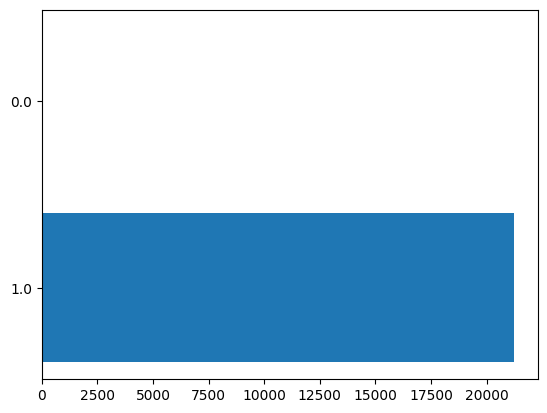

In [11]:

def countValues(dict, col):
    # Count the values in a column
    # df: dataframe
    # col: column to count
    # return: dataframe with the counts
    totalCount = collections.Counter()

    for df in dict.values():
        count = df[col].value_counts().to_dict()
        totalCount.update(count)        

    return totalCount

# Count the different values in the cmd_c column across all the dataframes
counter = countValues(dict, 'cmd_c')
print(counter)

plt.barh([str(k) for k in counter.keys()], counter.values())
plt.show()


The number of 0 values for the column cmd_c is irrelevant (when the executed command is not a check). For that reason, entries with these values should be dropped.

In [12]:
# Remove the rows with the value 0 in the cmd_c column
dropRowsWith = (lambda df, arg: df.drop(df[df[arg] == 0].index, inplace=True))
operateDFs(dict, dropRowsWith, 'cmd_c')

# Count the different values in the cmd_c column
print(countValues(dict, 'cmd_c'))

Counter({1.0: 21234})


#### original feature

In [13]:
# Count the different values for the original column for each dataframe
countValuesOp = (lambda df, arg: print(df[arg].value_counts().to_dict()))
operateDFs(dict, countValuesOp, 'original')
print("")

{'9jPK8KBWzjFmBx4Hb': 4338}
{'FwCGymHmbqcziisH5': 972}
{'gAeD3MTGCCv8YNTaK': 1764}
{'JC8Tij8o8GZb99gEJ': 665}
{'jyS8Bmceejj9pLbTW': 459}
{'PQAJE67kz8w5NWJuM': 1934}
{'sDLK7uBCbgZon3znd': 2216}
{'WGdhwKZnCu7aKhXq9': 283}
{'YH3ANm7Y5Qe5dSYem': 3478}
{'zoEADeCW2b2suJB2k': 1633}
{'zRAn69AocpkmxXZnW': 3492}



Every dataframe has the same value for the original column. This column is irrelevant.

#### cmd_n feature

In [14]:
df1["cmd_n"].value_counts()

prop5Ok     426
prop12Ok    413
prop6Ok     388
prop10Ok    350
prop8Ok     338
prop18Ok    241
prop4Ok     233
prop2Ok     227
prop11Ok    214
prop9Ok     177
prop14Ok    161
prop1Ok     158
prop7Ok     149
prop17Ok    148
prop16Ok    145
prop20Ok    131
prop13Ok    120
prop3Ok     110
prop19Ok    108
prop15Ok    101
Name: cmd_n, dtype: int64

In [15]:
df1["cmd_i"].value_counts()

4.0     426
11.0    413
5.0     388
9.0     350
7.0     338
17.0    241
3.0     233
1.0     227
10.0    214
8.0     177
13.0    161
0.0     158
6.0     149
16.0    148
15.0    145
19.0    131
12.0    120
2.0     110
18.0    108
14.0    101
Name: cmd_i, dtype: int64

First step is to encode the categorical value.

In [16]:
# Encode all the values in the cmd_n column
# Remove the prefix and suffix
df1.loc[df1["cmd_n"].str.contains("Ok"), "cmd_n"] = df1["cmd_n"].str[4:].str.removesuffix("Ok")
df1["cmd_n"] = df1["cmd_n"].astype('int') # transform to ints
df1.head()

,_id,cmd_c,cmd_i,cmd_n,code,derivationOf,original,sat,time,msg,theme
0,zKAYz8BCDmHKgNoSx,1.0,7.0,8,/**\n * Linear temporal logic revision exercis...,dvhCng5AdxC8MqjFy,9jPK8KBWzjFmBx4Hb,1.0,2020-12-13 23:28:11,NaN,NaN
1,8FmQ9PNWT2SXncTxX,1.0,9.0,10,/**\n * Linear temporal logic revision exercis...,5eT7wTw5kT8DwTbu2,9jPK8KBWzjFmBx4Hb,1.0,2019-11-11 21:54:33,NaN,NaN
2,eyGu5DYCrnk58G2fJ,1.0,6.0,7,/**\n * Linear temporal logic revision exercis...,niLmMRmm94Hz6ymcD,9jPK8KBWzjFmBx4Hb,1.0,2020-12-1 11:55:11,NaN,NaN
3,Akbr9Aq6WfBLHrvE8,1.0,18.0,19,/**\n * Linear temporal logic revision exercis...,DnAm62D7JaqDzyy5y,9jPK8KBWzjFmBx4Hb,1.0,2020-11-26 10:33:29,NaN,NaN
4,MNegade3hLiutxCru,1.0,10.0,11,/**\n * Linear temporal logic revision exercis...,cjK4u23ZAfYm8fatA,9jPK8KBWzjFmBx4Hb,1.0,2020-1-19 17:06:22,NaN,NaN


In [17]:
print("Correlation between cmd_n and cmd_i: ", df1["cmd_n"].corr(df1["cmd_i"]))

Correlation between cmd_n and cmd_i:  1.0


After encoding, cmd_n and cmd_i are highly correlated features. So we can drop one of this columns.

Now we will drop the irrelevant columns. 

In [18]:
# Drop columns that are not needed
dropColOp = (lambda df, arg: df.drop(columns=arg, axis=1, inplace=True))
operateDFs(dict, dropColOp, ["cmd_c", "cmd_n", "original", "time", "msg", "theme"])

dict["9jP"].head()

,_id,cmd_i,code,derivationOf,sat
0,zKAYz8BCDmHKgNoSx,7.0,/**\n * Linear temporal logic revision exercis...,dvhCng5AdxC8MqjFy,1.0
1,8FmQ9PNWT2SXncTxX,9.0,/**\n * Linear temporal logic revision exercis...,5eT7wTw5kT8DwTbu2,1.0
2,eyGu5DYCrnk58G2fJ,6.0,/**\n * Linear temporal logic revision exercis...,niLmMRmm94Hz6ymcD,1.0
3,Akbr9Aq6WfBLHrvE8,18.0,/**\n * Linear temporal logic revision exercis...,DnAm62D7JaqDzyy5y,1.0
4,MNegade3hLiutxCru,10.0,/**\n * Linear temporal logic revision exercis...,cjK4u23ZAfYm8fatA,1.0


### Code cleaning

The code in this dataset comes with comments that can be removed.

In [19]:
import re # regular expressions

def cleanCode(code):
    # Remove comments and empty lines
    # code: string with the code
    # return: string with the code without comments and empty lines
    code = re.sub(r"(/\*(.|\n)*?\*/)|(//.*)", "", code) # remove comments
    return re.sub(r"\n\n(?=\n)", "", code) # remove empty lines

def applyToCol(df, col, op):
    # Apply an operation to a column
    # df: dataframe
    # col: column to apply the operation
    # op: operation to apply
    # return: dataframe with the operation applied
    df[col] = df[col].apply(op)
    return df

# Clean the code column
cleanCodeOp = (lambda df, arg: applyToCol(df, arg, cleanCode))
operateDFs(dict, cleanCodeOp, "code")

df1.head()


,_id,cmd_i,code,derivationOf,sat
0,zKAYz8BCDmHKgNoSx,7.0,\nvar sig File {\n\tvar link : lone File\n}\nv...,dvhCng5AdxC8MqjFy,1.0
1,8FmQ9PNWT2SXncTxX,9.0,\nvar sig File {\n\tvar link : lone File\n}\nv...,5eT7wTw5kT8DwTbu2,1.0
2,eyGu5DYCrnk58G2fJ,6.0,\nvar sig File {\n\tvar link : lone File\n}\nv...,niLmMRmm94Hz6ymcD,1.0
3,Akbr9Aq6WfBLHrvE8,18.0,\nvar sig File {\n\tvar link : lone File\n}\nv...,DnAm62D7JaqDzyy5y,1.0
4,MNegade3hLiutxCru,10.0,\nvar sig File {\n\tvar link : lone File\n}\nv...,cjK4u23ZAfYm8fatA,1.0


We can also look for duplicate code.

In [20]:
print("Duplicate code: ", len(df1["code"])-len(df1["code"].drop_duplicates()))

Duplicate code:  775


There is a lot of entries with repeated code. However, if we drop duplicates we might lose information on student sessions.

## Add AST column

In [37]:
import jpype # Java

# Import the Java libraries
if not jpype.isJVMStarted():
    jpype.startJVM(classpath=['lib/Parser/parser.jar'])

# Import the Java classes
Parser = jpype.JClass('org.higena.A4FParser')

# Parse the code
code = df1["code"][0]
asts = Parser.parse(code)

asts.keys()

asts.get("this/prop1").getRoot()

#for ast in asts.values():
#    df1[ast.name][0] = ast.root

#df1["code"][0]


<java object 'org.higena.A4FNode'>

# Export clean data

In [26]:
from sqlalchemy import create_engine


def exportDataToDb(dict):
    # Export the dataframes to a database
    # dict: dictionary of dataframes
    
    # Connect to the database
    engine = create_engine("sqlite:///data/a4f_dataset.db", echo=True)

    for k, v in dict.items():
        v.to_sql(k, con=engine, if_exists='replace', index=False, index_label='_id')
        print(f"Exported {k}.")

# Export the dataframes to db
exportDataToDb(dict)

2023-02-10 14:21:11,187 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-02-10 14:21:11,187 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("9jP")
2023-02-10 14:21:11,188 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-02-10 14:21:11,189 INFO sqlalchemy.engine.Engine ROLLBACK
2023-02-10 14:21:11,190 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-02-10 14:21:11,191 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("9jP")
2023-02-10 14:21:11,192 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-02-10 14:21:11,192 INFO sqlalchemy.engine.Engine ROLLBACK
2023-02-10 14:21:11,193 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-02-10 14:21:11,194 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2023-02-10 14:21:11,194 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-02-10 14:21:11,196 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_temp_master WHERE type='table' AND name NOT LIKE 'sqlit